# load library

<font color="purple"> **I have to load reamining R library after making 'gene.info' file. When I am loading all libraries here, 'width' and 'reduce' function giving an error. To avoid this problem I will download remaining library after 'gene.info' step.**

In [1]:
suppressMessages(suppressWarnings(library("GenomicFeatures")))
suppressMessages(suppressWarnings(library("dplyr")))

# Global function

## Gene info file for FPKM calculation

In [2]:
txdb <- makeTxDbFromGFF("Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz",format="gtf")
# then collect the exons per gene id
exons.list.per.gene <- exonsBy(txdb,by="gene")
# then for each gene, reduce all the exons to a set of non overlapping exons, calculate their lengths (widths) and sum then :: https://www.biostars.org/p/83901/
# https://www.biostars.org/p/185665/
exonic.gene.sizes <- sum(width(reduce(exons.list.per.gene)))
gene.exon.counts <- lengths(exons.list.per.gene)
gene.info <- cbind(exonic.gene.sizes, gene.exon.counts)
colnames(gene.info) <- c("exon_length", "exon_number")


gtf <- rtracklayer::import("Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz")
gencode.vM28.gtf <- as.data.frame(gtf)
gencode.vM28.gtf.selected <- gencode.vM28.gtf %>%
  filter(type=="gene") %>%
  rename(Chr= seqnames, Type= type, GeneType=gene_biotype, Symbol= gene_name, Status= gene_version, Havana=gene_source, Length=width, Start = start, End=end, Strand=strand) %>%
  select(gene_id, Symbol,  Chr, Start, End, Strand,  GeneType,  Status, Havana, Length) #%>%
#filter(!grepl("chrM",Chr))


gene.info <- merge(gencode.vM28.gtf.selected, gene.info, by.x="gene_id", by.y= "row.names")
head(gene.info, n=3)

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



,gene_id,Symbol,Chr,Start,End,Strand,GeneType,Status,Havana,Length,exon_length,exon_number
,<chr>,<chr>,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3,108014596,108053462,-,protein_coding,5,ensembl_havana,38867,3262,9
2,ENSMUSG00000000003,Pbsn,X,76881507,76897229,-,protein_coding,16,ensembl_havana,15723,902,9
3,ENSMUSG00000000028,Cdc45,16,18599197,18630737,-,protein_coding,16,ensembl_havana,31541,3506,25


## Load remaing R libraries

In [3]:
suppressMessages(suppressWarnings(source("./jupyter_common.R")))
suppressMessages(suppressWarnings(library("DESeq2")))
suppressMessages(suppressWarnings(library("pheatmap")))
suppressMessages(suppressWarnings(library("RColorBrewer")))
suppressMessages(suppressWarnings(library("ggplot2")))
suppressMessages(suppressWarnings(library("PoiClaClu")))
suppressMessages(suppressWarnings(library("ggbeeswarm")))
suppressMessages(suppressWarnings(library("ggpubr")))
suppressMessages(suppressWarnings(library("tidyverse")))

## Read count matrix file

### STAR read count matrix

In [4]:
STAR_Matrix <- function(directory="", Stranded="farward")
{
  basedir <- directory  
  setwd(basedir)
  files <- dir(pattern="_ReadsPerGene.out.tab", path = basedir)
  counts <- c()
  for( i in seq_along(files) ){
    x <- read.table(file=files[i], sep="\t", header=F, as.is=T, skip = 4, row.names = 1) # First four lines are statistics
    colnames(x) <- c("unstranded", "farward", "reverse")
    counts <- cbind(counts, x[,grep(Stranded, colnames(x))]) ## In STAR column 1) ID 2) Unstranded 3) Farward Strand 4) Reverse Strand
  }
  rownames(counts) <- rownames(x) # set the row names
  colnames(counts) <- sub("_ReadsPerGene.out.tab","",files) # set the column names based on input file names, with pattern removed
  return(counts)
}

#Run command
#STAR_Counts <- STAR_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/STAR-COUNTS/", Stranded = "reverse")

### HTseq count matrix

In [5]:
HTSeq_Matrix <- function(directory="", Stranded= "reverse", counts="CDS")
{
    pwd <- getwd()
    if (counts=="genes") {
    basedir <- directory
    setwd(basedir)
    files <- dir(pattern=".genes.results", path = basedir)
    counts <- c()
    for( i in seq_along(files) ){
      x <- read.table(file=files[i], sep="\t", header=F, as.is=T, row.names = 1)
      colnames(x) <- c("reverse")
      x <- head(x, -5)
      counts <- cbind(counts, x[,grep(Stranded, colnames(x))]) #
    }
    rownames(counts) <- rownames(x)
    colnames(counts) <- sub(".genes.results","",files) 
    return(counts)
  }
  if (counts=="CDS") {
    basedir <- directory
    setwd(basedir)
    files <- dir(pattern=".CDS.counts", path = basedir)
    counts <- c()
    for( i in seq_along(files) ){
      x <- read.table(file=files[i], sep="\t", header=F, as.is=T, row.names = 1)
      colnames(x) <- c("reverse")
      x <- head(x, -5)
      counts <- cbind(counts, x[,grep(Stranded, colnames(x))]) #
    }
    rownames(counts) <- rownames(x) # set the row names
    colnames(counts) <- sub(".CDS.counts","",files) 
    return(counts)
  }
  setwd(pwd)
}

#Run command
#HTSeq_Counts_genes <- HTSeq_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/Translation/HTSeq-Counts/Gene/", Stranded = "reverse", counts = "genes")
#HTSeq_Counts_CDS <- HTSeq_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/Translation/HTSeq-Counts/CDS/", Stranded = "reverse", counts = "CDS")

### RSEM read count matrix

In [6]:
RSEM_Matrix <- function(directory="", count_type="FPKM")
{
    pwd <- getwd()
    basedir <- directory
    setwd(basedir)
    #count_type="FPKM" # "expected_count"   "TPM"              "FPKM"
    #This sequencing is based on reverse-stand protocol. Reads are calculated base on reverse strand, so I have to use column 4 of geneCount
    # https://www.biostars.org/p/360610/
    files <- dir(pattern=".RSEM.genes.results", path = basedir)
    counts <- c()
    for( i in seq_along(files) ){
        x <- read.table(file=files[i], sep="\t", header=T, as.is=T, row.names = 1) # First four lines are statistics
        counts <- cbind(counts, x[,grep(count_type, colnames(x))]) ## In STAR column 1) ID 2) Unstranded 3) Farward Strand 4) Reverse Strand
    }
    rownames(counts) <- rownames(x) # set the row names
    colnames(counts) <- sub(".RSEM.genes.results","",files) # set the column names based on input file names, with pattern removed
    counts <- round(counts)
    return(counts)
    setwd(pwd)
}

#Run command
#RSEM_Counts <- RSEM_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/RSEM_COUNTS/Counts/", count_type = "expected_count")
#RSEM_TPM <- RSEM_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/RSEM_COUNTS/Counts/", count_type = "TPM")
#RSEM_FPKM <- RSEM_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/RSEM_COUNTS/Counts/", count_type = "FPKM")

### FeatureCounts read count matrix

In [7]:
FeatureCounts_Matrix <- function(directory="", Stranded="reverse", counts="CDS")
{
    pwd <- getwd()
    if (counts=="genes") {
    basedir <- directory
    setwd(basedir)
    files <- dir(pattern="_featureCounts.gene.out", path = basedir)
    counts <- c()
    for( i in seq_along(files) ){
      x <- read.table(file=files[i], sep="\t", header=F, as.is=T, row.names = 1, skip = 2) # First four lines are statistics
      colnames(x) <- c("V2", "V3", "V4", "V5", "V6", "reverse")
      counts <- cbind(counts, x[,grep(Stranded, colnames(x))]) ## In STAR column 1) ID 2) Unstranded 3) Farward Strand 4) Reverse Strand
    }
    rownames(counts) <- rownames(x) # set the row names
    colnames(counts) <- sub("_featureCounts.gene.out","",files) # set the column names based on input file names, with pattern removed
    return(counts)
  }
  if (counts=="CDS") {
    basedir <- directory
    setwd(basedir)
    files <- dir(pattern="_featureCounts.CDS.out", path = basedir)
    counts <- c()
    for( i in seq_along(files) ){
      x <- read.table(file=files[i], sep="\t", header=F, as.is=T, row.names = 1, skip = 2) # First four lines are statistics
      colnames(x) <- c("V2", "V3", "V4", "V5", "V6", "reverse")
      counts <- cbind(counts, x[,grep(Stranded, colnames(x))]) ## In STAR column 1) ID 2) Unstranded 3) Farward Strand 4) Reverse Strand
    }
    rownames(counts) <- rownames(x) # set the row names
    colnames(counts) <- sub("_featureCounts.CDS.out","",files) # set the column names based on input file names, with pattern removed
    return(counts)
  }
  setwd(pwd)
}
#Run command
#FeatureCounts_genes <- FeatureCounts_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/Translation/FeatureCounts/Gene/", Stranded = "reverse", counts = "genes")
#FeatureCounts_CDS <- FeatureCounts_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/Translation/FeatureCounts/CDS/", Stranded = "reverse", counts = "CDS")

## TCGA FPKM and FPKM-UQ (Raw/log2) calculation
This code also have option for TPM, CPM and RPKM calculation

In [8]:
GDC_FPKM <- function(mat, gene_lengths, method = "FPKM", log2_Norm=TRUE) 
{
    verb("Total genes: %d\n", nrow(mat))
    genes <- intersect(rownames(mat), gene_lengths$gene_id)
    gene_lengths <- gene_lengths[gene_lengths$gene_id %in% genes,]
    mat <- mat[genes,]
    protein_coding <- gene_lengths[grep("protein_coding", gene_lengths$GeneType),]
    verb("Total protein-coding genes: %d\n", nrow(protein_coding))
    RC_g = mat
    RC.pc <- mat[protein_coding$gene_id,]
    RC_pc <- colSums(mat[protein_coding$gene_id,])
    verb("The total count of protein-coding genes: %d\n", RC_pc)
    eff_leng <- gene_lengths$exon_length
    names(eff_leng) <- gene_lengths$gene_id
    head(RC_g)
    #eff_leng <- t(eff_leng)
    uqs <- apply(RC.pc, 2, quantile, 0.75)
    verb("The 75 perentile count of protein-coding genes: %f\n", uqs)
    if (method == "FPKM") {
        #uqs <- apply(RC.pc, 2, quantile, 0.75)
        #verb("The 75 perentile count of protein-coding genes: %d\n", uqs)
        fpkm <- do.call(cbind, lapply(1:ncol(RC_g), function(i) {
            (((RC_g[, i]) * 1e9) / (eff_leng *RC_pc[i]))
        }))
        colnames(fpkm) <- colnames(RC_g)
        rownames(fpkm) <- rownames(RC_g)
        #return(fpkm)
        if(log2_Norm==TRUE){
            return(log2(fpkm+1))}
        else{return(fpkm)}
    }
    if(method=="FPKM-UQ") {
        uqs <- apply(RC.pc, 2, quantile, 0.75)
        #verb("The 75 perentile count of protein-coding genes: %d\n", uqs)
        fpkm <- do.call(cbind, lapply(1:ncol(RC_g), function(i) {
            (((RC_g[, i]) * 1e9) / (eff_leng * uqs[i]))
        }))
        colnames(fpkm) <- colnames(RC_g)
        rownames(fpkm) <- rownames(RC_g)
        #return(fpkm)
        if(log2_Norm==TRUE){
            return(log2(fpkm+1))}
        else{return(fpkm)}
    }
}
## Run command for FPKM/FPKM-UQ
# STAR_FPKM <- GDC_FPKM(mat = STAR_Counts, gene_lengths = gene_lengths, method = "FPKM")
# STAR_FPKM_UQ <- GDC_FPKM(mat = STAR_Counts, gene_lengths = gene_lengths, method = "FPKM-UQ")

#####################################################################
#####################################################################
################## Normalized read count matrix #####################
# https://gist.github.com/slowkow/6e34ccb4d1311b8fe62e
# https://www.reneshbedre.com/blog/expression_units.html
# This RPKM, TPM, CPM is same as Python 
rpkm <- function(counts, lengths) {
  rate <- (counts / lengths) * 1e9
  rate / sum(counts, na.rm = TRUE) }

tpm <- function(counts, lengths) {
  rate <- (counts / lengths)*1e3
  (rate / sum(rate, na.rm = TRUE)) * 1e6}

cpm <- function(counts, lengths)
{  (counts * 1e6) /sum(counts, na.rm = TRUE)}

## Read counts

In [9]:
pwd <- getwd()
RSEM.Counts.RNAseq <- RSEM_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/jupyter codes/FPKM/RSEM_counts/", count_type = "expected_count")
HTseq.Counts.RNAseq <- HTSeq_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/jupyter codes/FPKM/htseqCounts/", Stranded = "reverse", counts = "genes")

RSEM.Counts.Riboseq <- RSEM_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/jupyter codes/FPKM/RSEM_counts_Ribo/", count_type = "expected_count")
HTseq.Counts.Riboseq <- HTSeq_Matrix(directory = "C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/jupyter codes/FPKM/htseqCounts_Ribo/", Stranded = "reverse", counts = "genes")
setwd(pwd)

f_meta_tags <- grepl("^__|rDNA_promoter|rDNA", rownames(RSEM.Counts.RNAseq))
RSEM.Counts.RNAseq <- RSEM.Counts.RNAseq[!f_meta_tags,]
f_meta_tags <- grepl("^__|rDNA_promoter|rDNA", rownames(HTseq.Counts.RNAseq))
HTseq.Counts.RNAseq <- HTseq.Counts.RNAseq[!f_meta_tags,]
f_meta_tags <- grepl("^__|rDNA_promoter|rDNA", rownames(RSEM.Counts.Riboseq))
RSEM.Counts.Riboseq <- RSEM.Counts.Riboseq[!f_meta_tags,]
f_meta_tags <- grepl("^__|rDNA_promoter|rDNA", rownames(HTseq.Counts.Riboseq))
HTseq.Counts.Riboseq <- HTseq.Counts.Riboseq[!f_meta_tags,]
setwd(pwd)

In [10]:
RSEM.Counts.RNAseq.FPKM <- GDC_FPKM(mat = as.matrix(RSEM.Counts.RNAseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = FALSE)
RSEM.Counts.RNAseq.FPKM.log2 <- GDC_FPKM(mat = as.matrix(RSEM.Counts.RNAseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = TRUE)

HTseq.Counts.RNAseq.FPKM <- GDC_FPKM(mat = as.matrix(HTseq.Counts.RNAseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = FALSE)
HTseq.Counts.RNAseq.FPKM.log2 <- GDC_FPKM(mat = as.matrix(HTseq.Counts.RNAseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = TRUE)

RSEM.Counts.Riboseq.FPKM <- GDC_FPKM(mat = as.matrix(RSEM.Counts.Riboseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = FALSE)
RSEM.Counts.Riboseq.FPKM.log2 <- GDC_FPKM(mat = as.matrix(RSEM.Counts.Riboseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = TRUE)

HTseq.Counts.Riboseq.FPKM <- GDC_FPKM(mat = as.matrix(HTseq.Counts.Riboseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = FALSE)
HTseq.Counts.Riboseq.FPKM.log2 <- GDC_FPKM(mat = as.matrix(HTseq.Counts.Riboseq), gene_lengths = gene.info, method = "FPKM", log2_Norm = TRUE)

Total genes: 55416
Total protein-coding genes: 21885
The total count of protein-coding genes: 5559012
The total count of protein-coding genes: 3867203
The total count of protein-coding genes: 4554160
The total count of protein-coding genes: 4263046
The total count of protein-coding genes: 6444178
The total count of protein-coding genes: 6649751
The total count of protein-coding genes: 3588768
The total count of protein-coding genes: 6005517
The total count of protein-coding genes: 4474392
The 75 perentile count of protein-coding genes: 190.000000
The 75 perentile count of protein-coding genes: 130.000000
The 75 perentile count of protein-coding genes: 156.000000
The 75 perentile count of protein-coding genes: 130.000000
The 75 perentile count of protein-coding genes: 206.000000
The 75 perentile count of protein-coding genes: 211.000000
The 75 perentile count of protein-coding genes: 106.000000
The 75 perentile count of protein-coding genes: 180.000000
The 75 perentile count of protein-

## DESeq2/edgeR based normalization for Boxplot

### Gene filtering

In [11]:
Gene_filtering <- function(mat, Count_filter=0){
  not_all_na <- function(x) any(!is.na(x))
  if(!isTRUE(is.data.frame(mat))) # If not dataFrame convert it.
    mat <- as.data.frame(mat)
  mat <- mat %>%
    dplyr::select(where(not_all_na))
  mat <- subset(mat, apply(mat, 1, sum) != 0)
  #mat <- subset(mat, apply(mat, 2, sum) != 0)# not_all_na already did this
  mat <- mat[apply(mat,1,function(x) sum(x<=0))< ncol(mat)*0.5,]##Remove genes which have over 50% zero
  mat <- subset(mat, apply(mat, 1, sum) >= Count_filter)
  return(mat)}

exp <- Gene_filtering(as.data.frame(RSEM.Counts.RNAseq))
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))

In [12]:
dim(RSEM.Counts.RNAseq)
head(exp, 5)

[1] 55416     9

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,562,474,492,330,611,631,285,513,405
ENSMUSG00000000028,136,97,129,69,119,116,46,67,51
ENSMUSG00000000056,371,257,329,117,218,193,116,182,150
ENSMUSG00000000058,672,569,638,227,429,539,268,496,347
ENSMUSG00000000078,547,409,452,873,1353,1360,825,1241,1097


In [13]:
setwd('C:/Users/nmishra/Dropbox/PC/Desktop/Total RNAseq EMT/jupyter codes')
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


In [14]:
ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [15]:
sampleDists <- dist(t(assay(vsd)))
sampleDists

          JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007
JBQS002 10.219309                                                            
JBQS003  8.823691  9.979879                                                  
JBQS004 38.629171 39.469800 39.075927                                        
JBQS005 38.252840 39.074145 38.736299 11.460481                              
JBQS006 38.084948 38.927214 38.586918 11.521111  8.405871                    
JBQS007 41.319799 42.376185 41.962264 13.850098 13.969255 13.623016          
JBQS008 41.519154 42.797377 42.271416 14.201929 13.036266 13.183144 10.209767
JBQS009 41.154179 42.148995 41.763513 15.649050 15.172780 14.775020 14.250114
          JBQS008
JBQS002          
JBQS003          
JBQS004          
JBQS005          
JBQS006          
JBQS007          
JBQS008          
JBQS009 14.315206

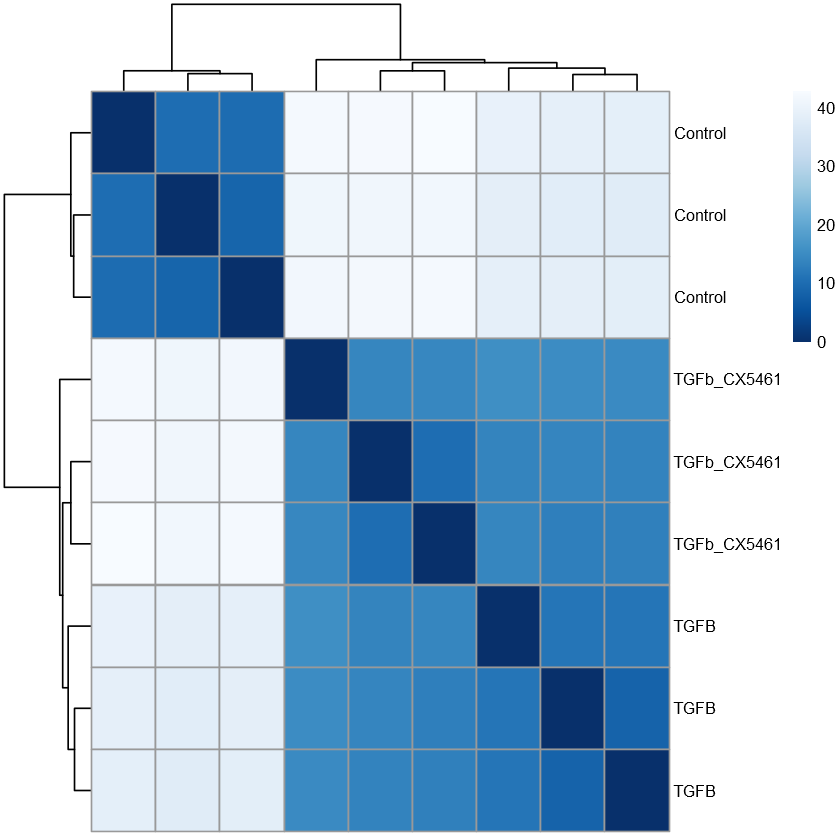

In [16]:
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( vsd$condition, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)


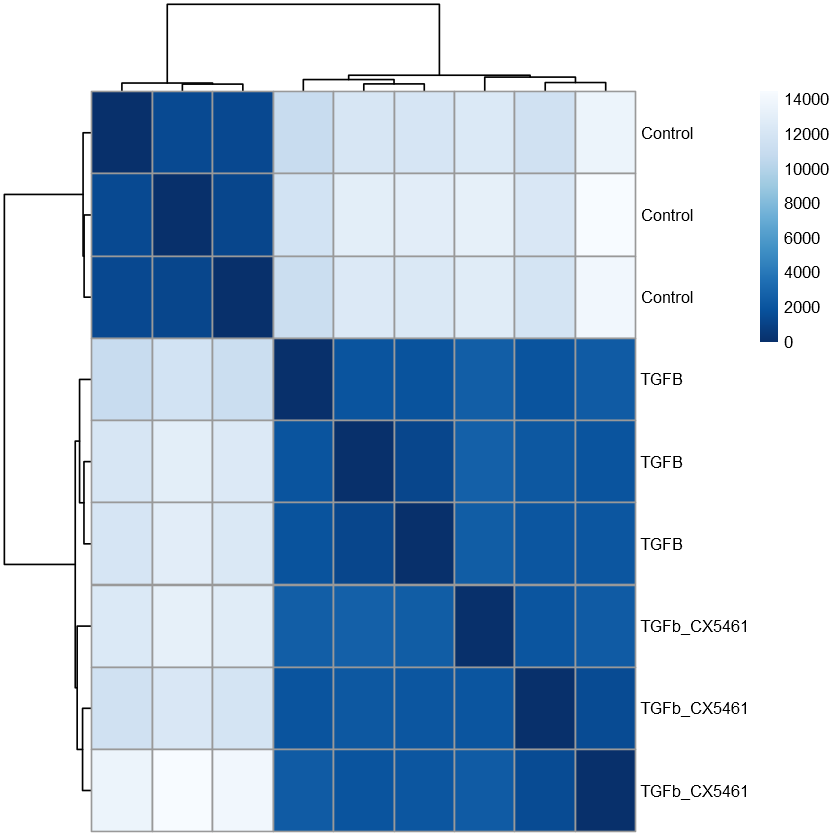

In [17]:
#library("PoiClaClu")
poisd <- PoissonDistance(t(counts(ddsMat)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( ddsMat$condition, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

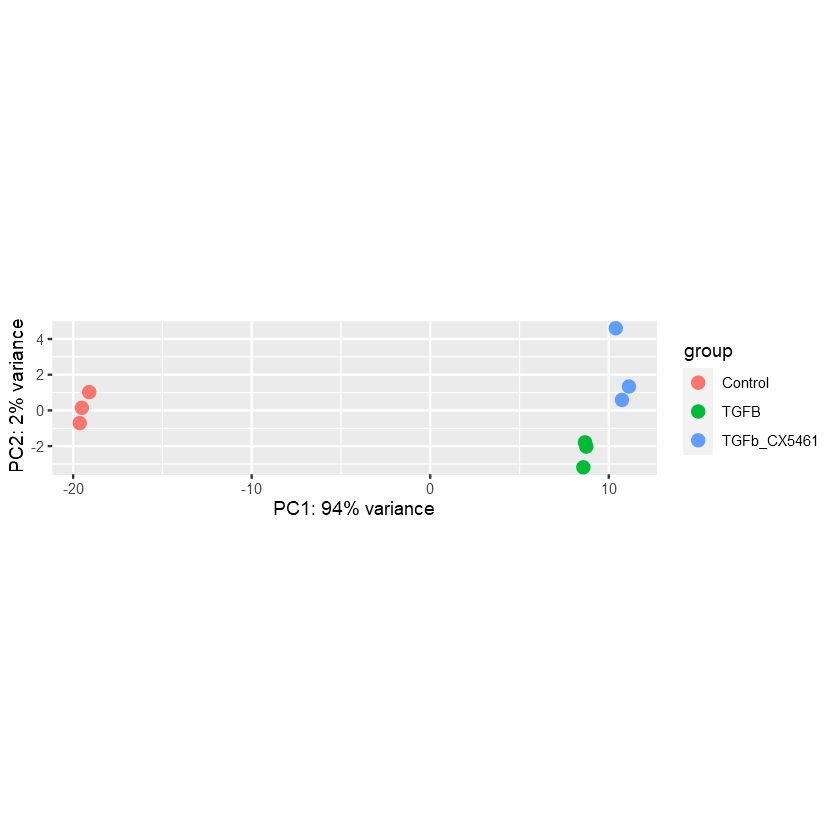

In [18]:
plotPCA(vsd, intgroup = c("condition"))

In [19]:
dds <- DESeq(ddsMat)
res <- results(dds)

res <- results(dds, contrast = c("condition", "TGFB", "TGFb_CX5461"))
summary(res)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 14962 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 413, 2.8%
LFC < 0 (down)     : 536, 3.6%
outliers [1]       : 7, 0.047%
low counts [2]     : 4641, 31%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [20]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)
resLFC1 <- results(dds, lfcThreshold=1)
table(resLFC1$padj < 0.01)


FALSE  TRUE 
 7836  6248 


FALSE  TRUE 
12760  1034 

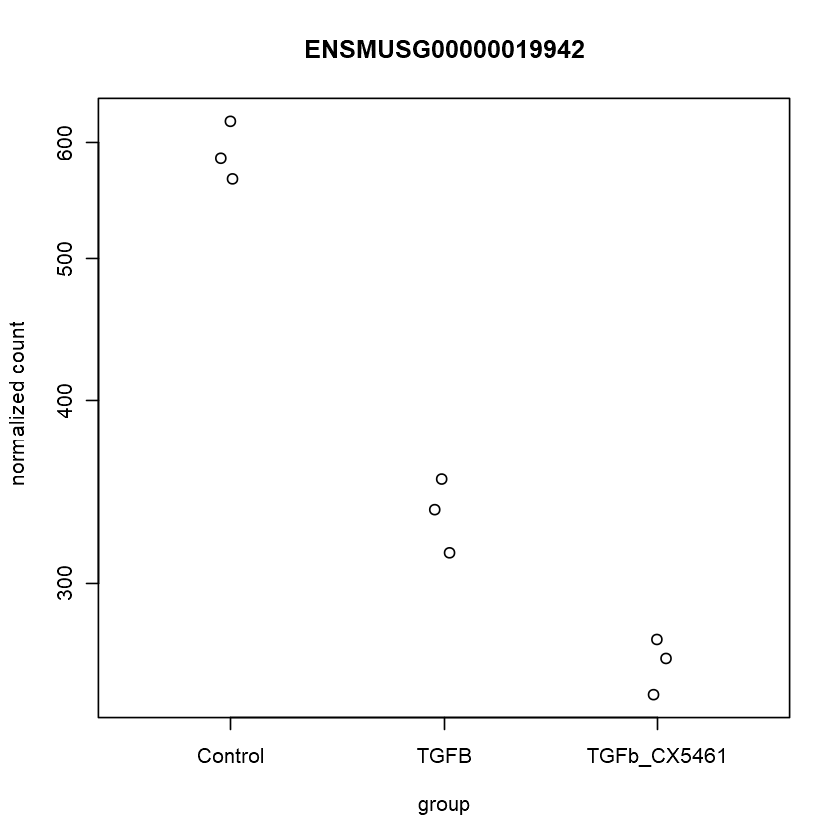

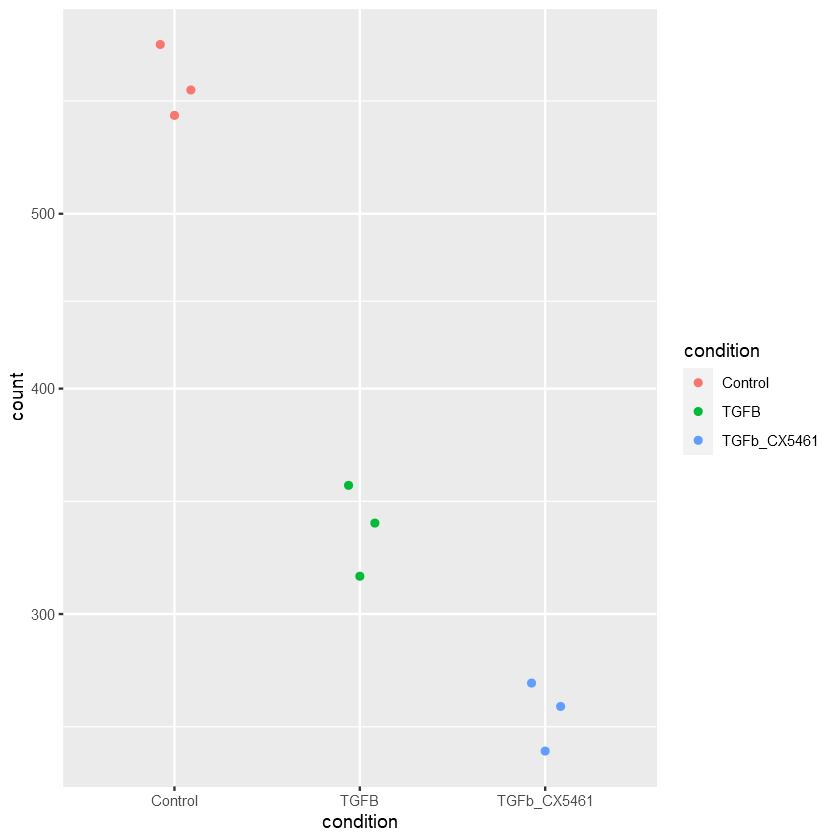

In [21]:
#library("ggbeeswarm")
# topGene: Cdkn1a [cyclin-dependent kinase inhibitor 1A (P21)] ENSMUSG00000023067
plotCounts(dds, gene = "ENSMUSG00000019942", intgroup=c("condition"))

geneCounts <- plotCounts(dds, gene = "ENSMUSG00000019942", intgroup = c("condition"),
                         returnData = TRUE)
ggplot(geneCounts, aes(x = condition, y = count, color = condition)) +
  scale_y_log10() +  geom_beeswarm(cex = 3)

## VST normalized data for Boxplot

## Plot for Cdk1: ENSMUSG00000019942

### RNA-seq Boxplot Cdk1

<font color="red"> <b>List of genes for the Boxplot for RNA-seq, Ribo-seq, Proteomics and Phospho-proteomics <br>CCNB1, TOP2A, KIF11, CDC20, PTTG1, NUSAP1, ESPL1, AURKA, CCNB2, PLK1, CENPE, TPX2, CENPF, TACC3, ANLN

In [208]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [209]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000019942",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007   JBQS008 
10.051553 10.101550 10.024056  9.575495  9.656523  9.622463  9.484848  9.465637 
  JBQS009 
 9.429628

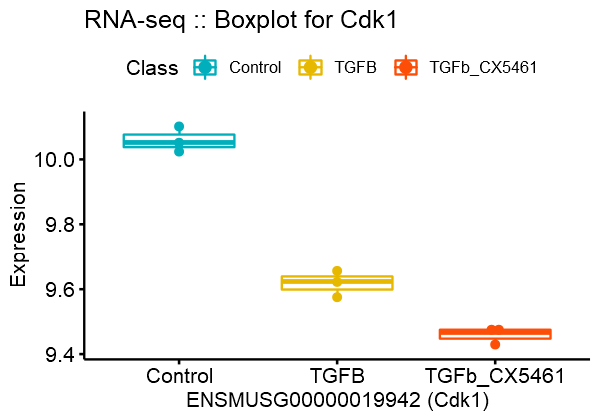

In [210]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
     add = "boxplot",
                title="RNA-seq :: Boxplot for Cdk1",
                xlab="ENSMUSG00000019942 (Cdk1)",
      color = "Class", fill = "Class",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cdk1 Boxplot %s", condstr))

In [211]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000023067",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007   JBQS008 
10.014435  9.944782 10.035892  9.681803  9.712363  9.647080 10.722048 10.755492 
  JBQS009 
10.693410

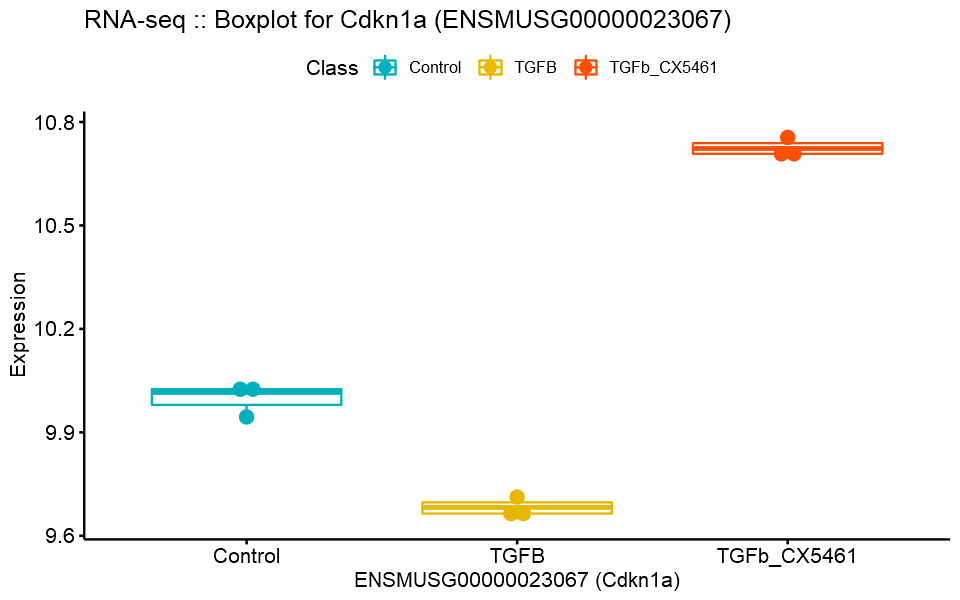

In [212]:
gp <- ggdotplot(data, "Class", "Expression",
     add = "boxplot",
                title="RNA-seq :: Boxplot for Cdkn1a (ENSMUSG00000023067)",
                xlab="ENSMUSG00000023067 (Cdkn1a)",
      color = "Class", fill = "Class",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("RNA-seq Cdkn1a Boxplot %s", condstr))

### Ribo-seq Boxplot Cdk1

In [213]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable

dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [214]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [146]:
dds.Ribo <- DESeq(dds.Ribo)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [147]:
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000019942",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)

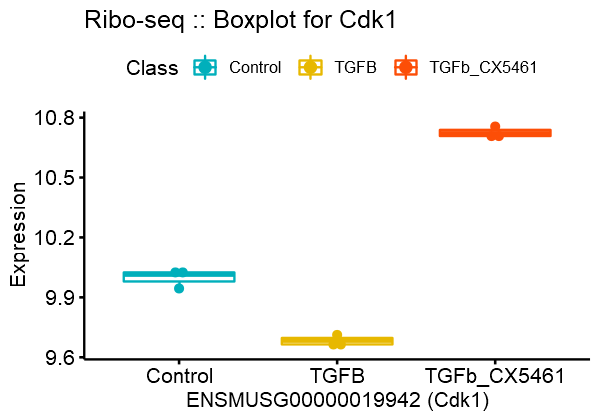

In [215]:
gp <- ggdotplot(data, "Class", "Expression",
     add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdk1",
                xlab="ENSMUSG00000019942 (Cdk1)",
      color = "Class", fill = "Class",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))

print_figure(gp, width = 5, height = 3.5, file = sprintf("Ribo-seq Cdk1 Boxplot %s", condstr))

In [216]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000023067",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
9.073568 9.042805 9.010798 8.669710 8.643248 8.641861 9.096889 9.153778 
  RD0186 
9.149696

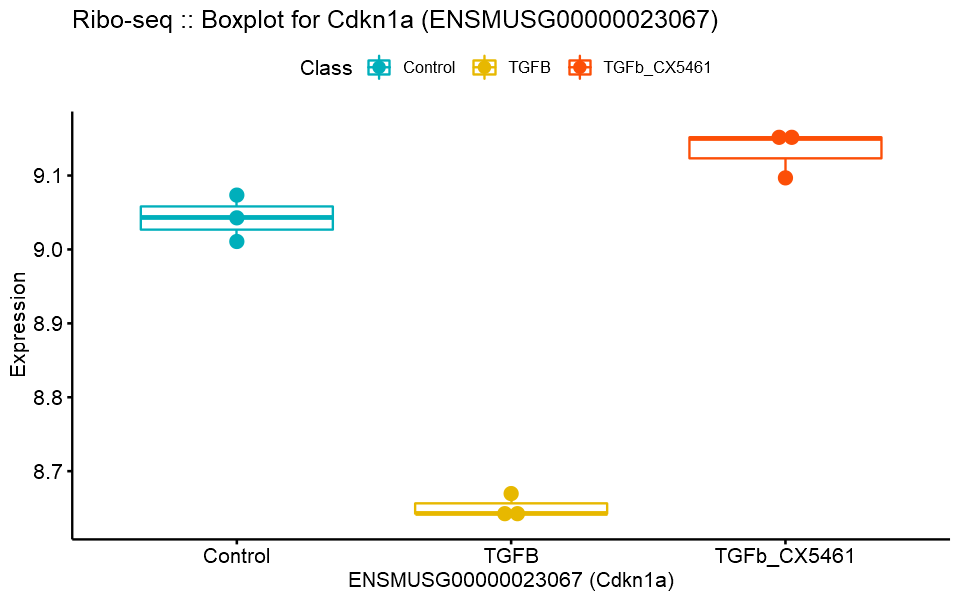

In [217]:
gp <- ggdotplot(data, "Class", "Expression",
     add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdkn1a (ENSMUSG00000023067)",
                xlab="ENSMUSG00000023067 (Cdkn1a)",
      color = "Class", fill = "Class",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cdkn1a Boxplot %s", condstr))

## Plot for Cyclin D1 (Ccnd1): ENSMUSG00000070348

### RNA-seq Cyclin D1

In [194]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [195]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000070348",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
11.47062 11.56718 11.49999 10.84049 10.80820 10.80575 11.02881 10.90788 
 JBQS009 
10.87715

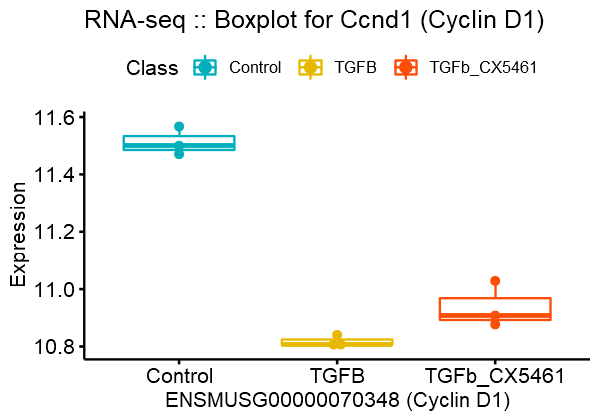

In [196]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnd1 (Cyclin D1)",
                xlab="ENSMUSG00000070348 (Cyclin D1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cyclin D1 Boxplot %s", condstr))

### Ribo-seq Cyclin D1

In [197]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [198]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [199]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000070348",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
9.681036 9.580007 9.475339 9.052769 9.054419 8.946053 9.219358 9.074408 
  RD0186 
9.236732

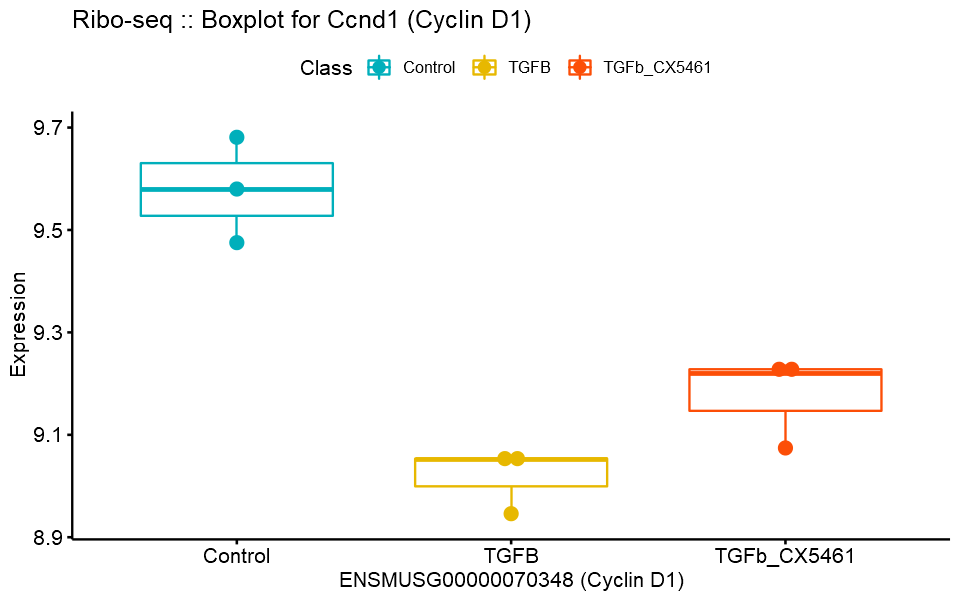

In [200]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnd1 (Cyclin D1)",
                xlab="ENSMUSG00000070348 (Cyclin D1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cyclin D1 Boxplot %s", condstr))

## Cyclin B1 (Ccnb1) ENSMUSG00000041431

### RNA-seq Cyclin B1 (Ccnb1)

In [225]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [226]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000041431",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.867550 9.933470 9.925097 9.305853 9.400293 9.401009 9.098334 9.133383 
 JBQS009 
9.223845

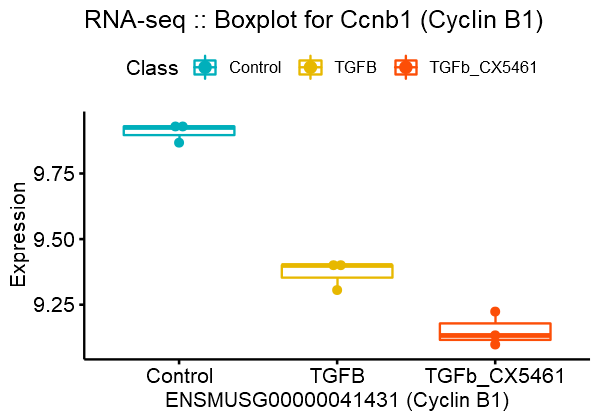

In [227]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnb1 (Cyclin B1)",
                xlab="ENSMUSG00000041431 (Cyclin B1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cyclin B1 (Ccnb1) Boxplot %s", condstr))

### Ribo-seq Cyclin B1 (Ccnb1)

In [228]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [229]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [230]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000041431",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.266326 8.368819 8.315214 8.131669 8.083757 8.205969 8.435252 8.403165 
  RD0186 
8.450207

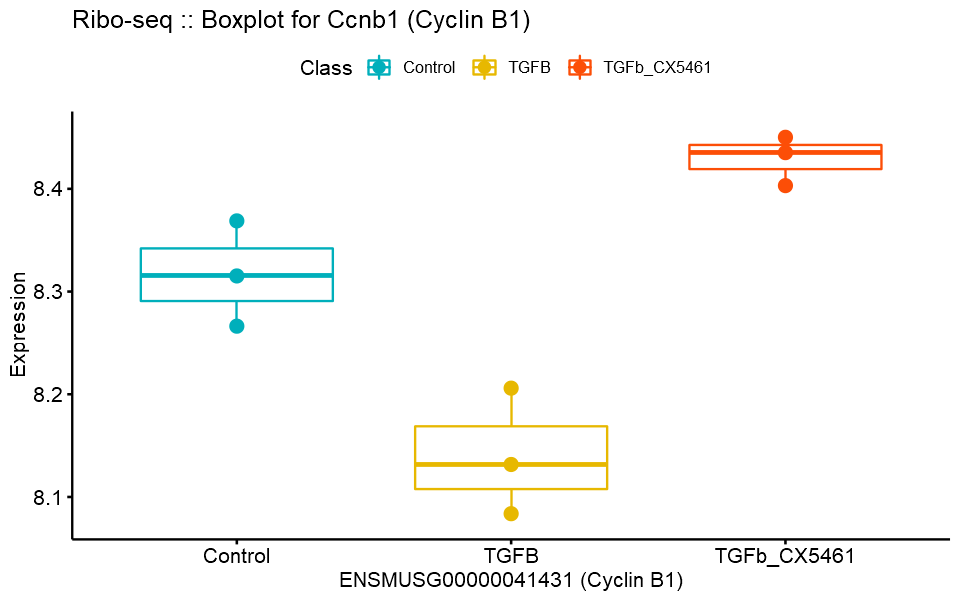

In [231]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnb1 (Cyclin B1)",
                xlab="ENSMUSG00000041431 (Cyclin B1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cyclin B1 (Ccnb1) Boxplot %s", condstr))

## Cyclin B2 (Ccnb2) ENSMUSG00000032218

### RNA-seq Cyclin B2 (Ccnb2)

In [232]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [233]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000032218",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.676519 9.693359 9.677655 9.125845 9.098417 9.057157 8.936137 8.883452 
 JBQS009 
8.987009

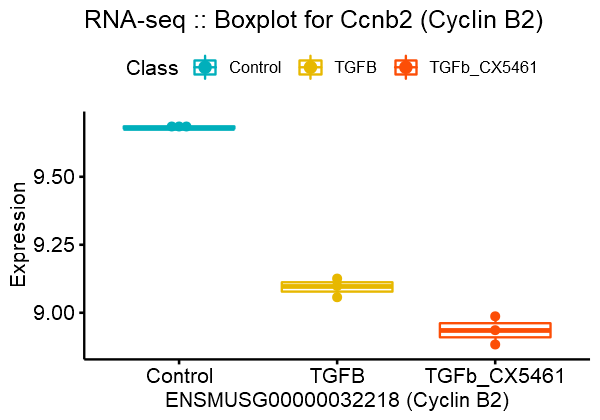

In [234]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnb2 (Cyclin B2)",
                xlab="ENSMUSG00000032218 (Cyclin B2)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cyclin B2 (Ccnb2) Boxplot %s", condstr))

### Ribo-seq Cyclin B2 (Ccnb2)

In [239]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [240]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [241]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000032218",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.012299 8.052346 8.051314 7.947328 8.024881 8.078479 7.991800 7.946387 
  RD0186 
7.947016

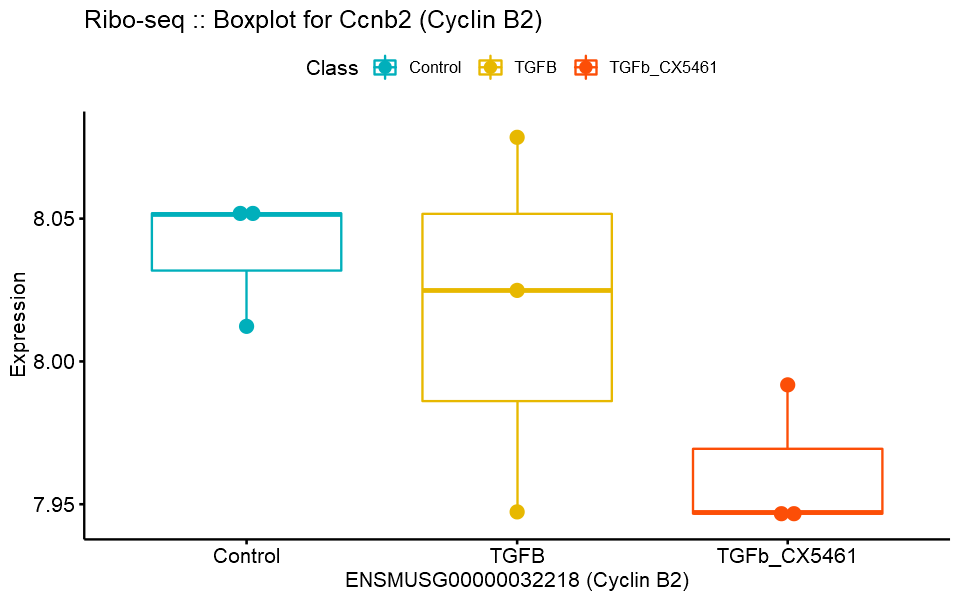

In [242]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnb2 (Cyclin B2)",
                xlab="ENSMUSG00000032218 (Cyclin B2)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cyclin B2 (Ccnb2) Boxplot %s", condstr))

## Plot for Cyclin D2 (Ccnd2): ENSMUSG00000000184

### RNA-seq Cyclin D1

In [179]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [180]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000000184",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
11.28704 11.28777 11.28222 10.51773 10.50268 10.46405 10.67677 10.62575 
 JBQS009 
10.75807

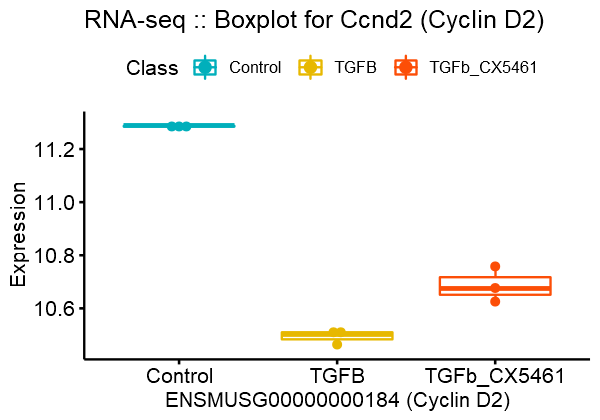

In [181]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnd2 (Cyclin D2)",
                xlab="ENSMUSG00000000184 (Cyclin D2)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cyclin D2 Boxplot %s", condstr))

### Ribo-seq Cyclin D2

In [182]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [183]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [184]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000000184",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.844311 8.860036 8.869276 8.479988 8.513741 8.299019 8.323505 8.386430 
  RD0186 
8.376619

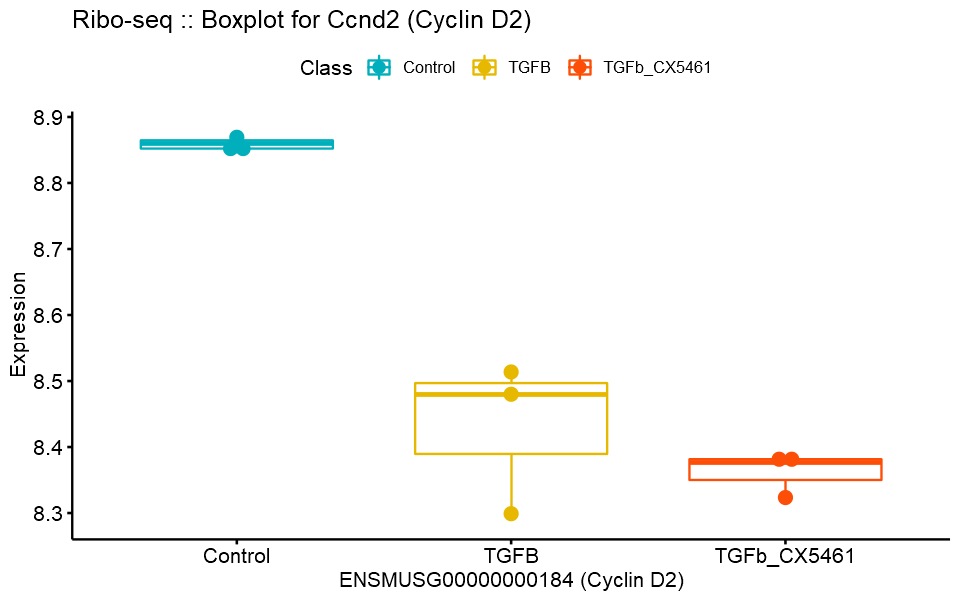

In [185]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnd2 (Cyclin D2)",
                xlab="ENSMUSG00000000184 (Cyclin D2)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cyclin D2 Boxplot %s", condstr))

## Plot for Cyclin D3 (Ccnd3): ENSMUSG00000034165

### RNA-seq Cyclin D3

In [187]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [188]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000034165",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007   JBQS008 
10.097891 10.127782 10.097681 10.027746  9.793483  9.904343  9.912560  9.869820 
  JBQS009 
 9.713854

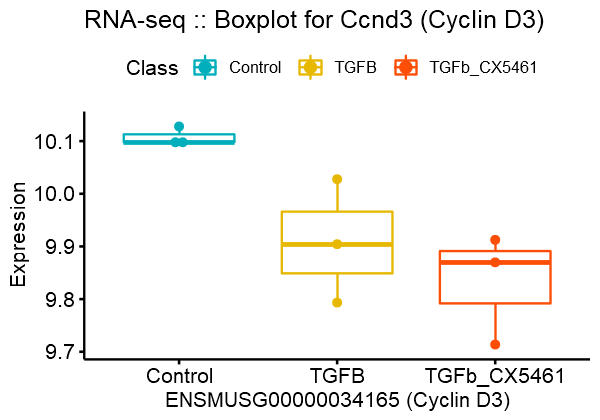

In [189]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnd3 (Cyclin D3)",
                xlab="ENSMUSG00000034165 (Cyclin D3)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cyclin D3 Boxplot %s", condstr))

### Ribo-seq Cyclin D3

In [190]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [191]:
condstr <- "Ribo-seq"
exp.Ribo <- Gene_filtering(as.data.frame(RSEM.Counts.Riboseq))
head(exp.Ribo, 3)

,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,85,98,124,43,77,64,87,94,58
ENSMUSG00000000028,14,16,19,8,10,17,16,15,14
ENSMUSG00000000056,38,31,48,16,32,27,30,23,17


In [192]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000034165",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.266326 8.208479 8.283236 8.060911 8.191868 8.216029 8.360531 8.080432 
  RD0186 
8.147136

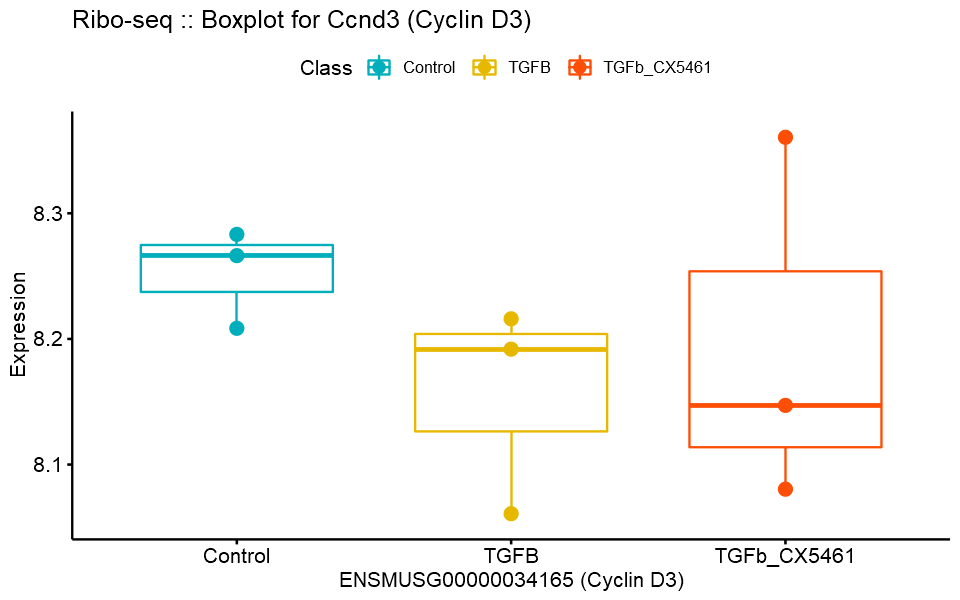

In [193]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnd3 (Cyclin D3)",
                xlab="ENSMUSG00000034165 (Cyclin D3)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cyclin D3 Boxplot %s", condstr))

## Plot for Cyclinb (Ccnb1): ENSMUSG00000041431

### RNA-seq CyclinB1 (Ccnb1)

In [163]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [164]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000041431",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.867550 9.933470 9.925097 9.305853 9.400293 9.401009 9.098334 9.133383 
 JBQS009 
9.223845

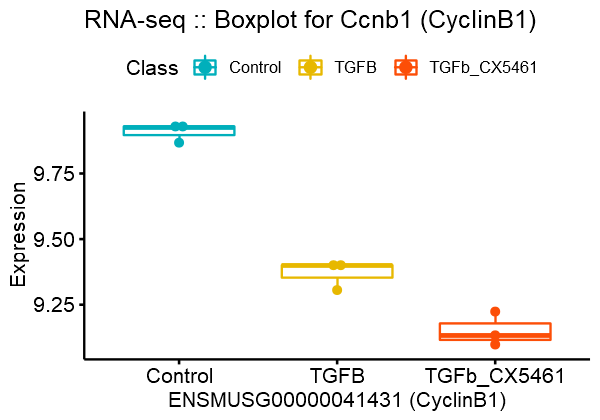

In [165]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Ccnb1 (CyclinB1)",
                xlab="ENSMUSG00000041431 (CyclinB1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq CyclinB1 Boxplot %s", condstr))

### Ribo-seq CyclinB1(Ccnb1)

In [166]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [169]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000041431",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.266326 8.368819 8.315214 8.131669 8.083757 8.205969 8.435252 8.403165 
  RD0186 
8.450207

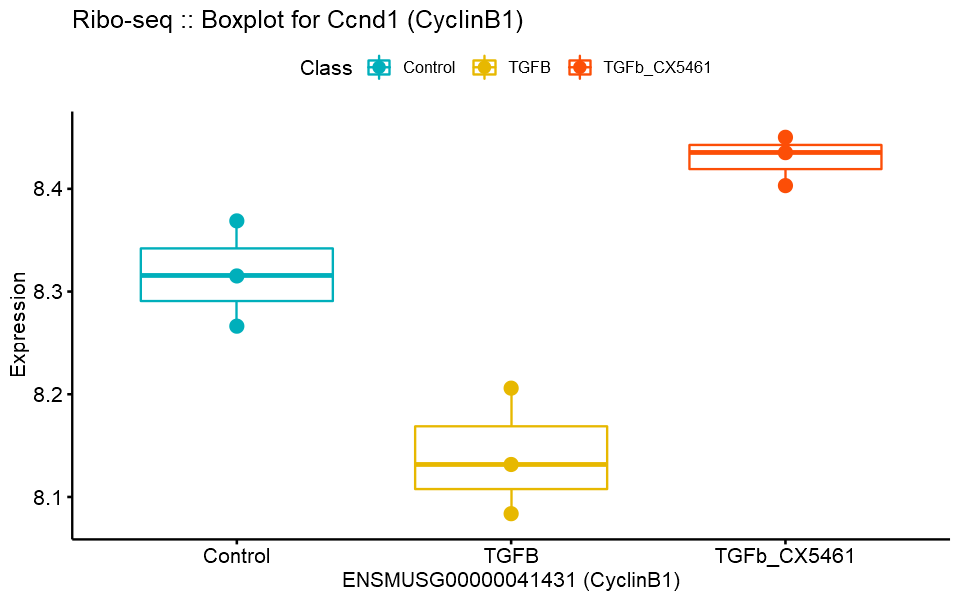

In [170]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Ccnd1 (CyclinB1)",
                xlab="ENSMUSG00000041431 (CyclinB1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq CyclinB1 Boxplot %s", condstr))

## Plot for Gene: Top2a (ENSMUSG00000020914)

### RNA-seq Top2a (ENSMUSG00000020914)

In [47]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [48]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000020914",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007   JBQS008 
10.839494 10.931680 10.952243  9.904849  9.922502  9.941749  9.783099  9.578600 
  JBQS009 
 9.981043

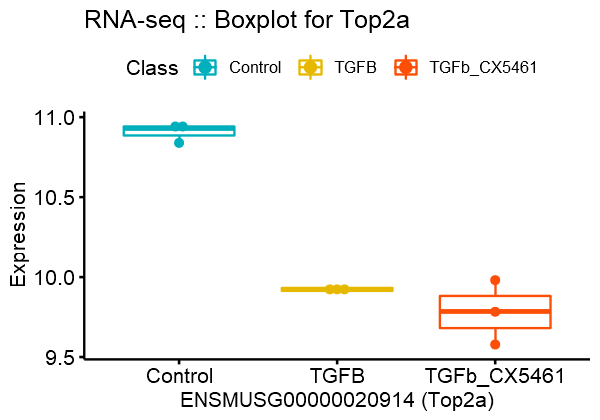

In [49]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Top2a",
                xlab="ENSMUSG00000020914 (Top2a)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Top2a Boxplot %s", condstr))

### Ribo-seq Top2a

In [160]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [161]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000020914",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.628898 8.637992 8.791544 8.633667 8.538913 8.528051 8.666228 8.595504 
  RD0186 
8.694101

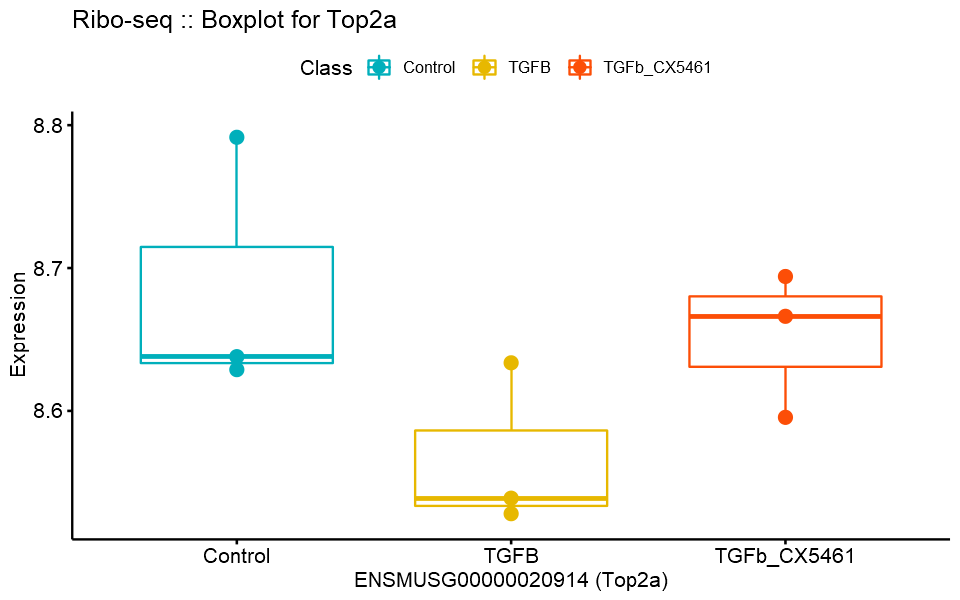

In [162]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Top2a",
                xlab="ENSMUSG00000020914 (Top2a)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Top2a Boxplot %s", condstr))

## Plot for Gene: Kif11 ENSMUSG00000012443

### RNAseq Kif11

In [79]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [80]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000012443",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.711366 9.832857 9.778150 8.877019 9.060021 9.078861 8.769212 8.744473 
 JBQS009 
8.900340

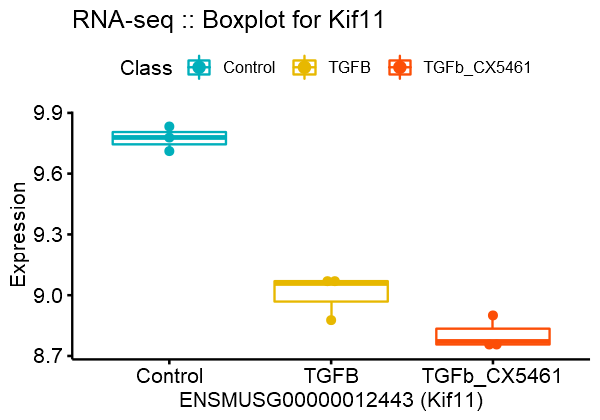

In [81]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Kif11",
                xlab="ENSMUSG00000012443 (Kif11)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Kif11 Boxplot %s", condstr))

### Ribo-seq Kif11

In [97]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [98]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000012443",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.143027 8.129468 8.146797 8.079785 8.169945 8.091728 7.991800 7.975277 
  RD0186 
8.008639

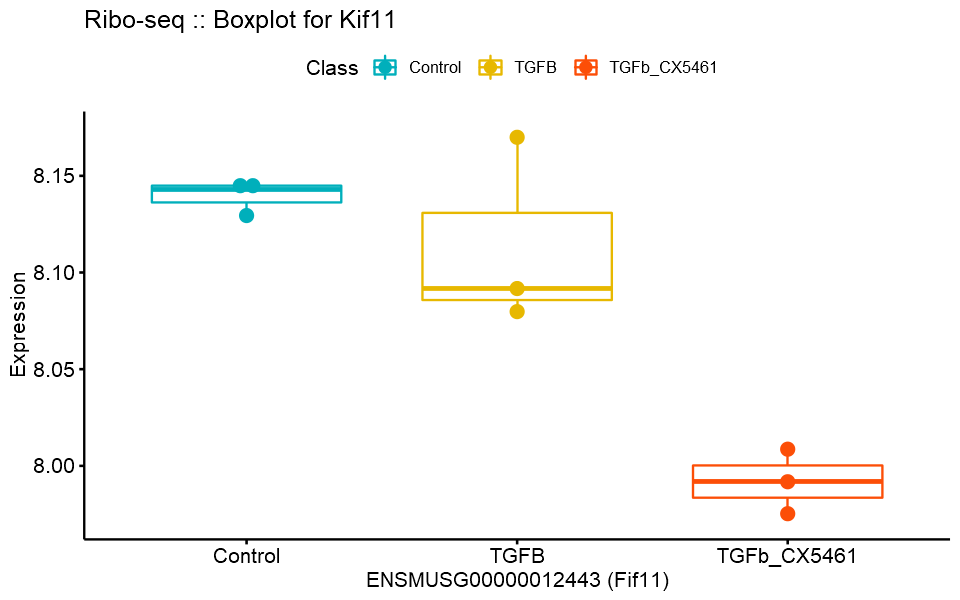

In [99]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Kif11",
                xlab="ENSMUSG00000012443 (Fif11)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Kif11 Boxplot %s", condstr))

## Plot for Gene: cell division cycle 20 (Cdc20) ENSMUSG00000006398

### RNAseq Cdc20

In [85]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [86]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000006398",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.789827 9.738749 9.774509 9.157724 9.122231 9.208195 9.093237 9.009735 
 JBQS009 
9.097623

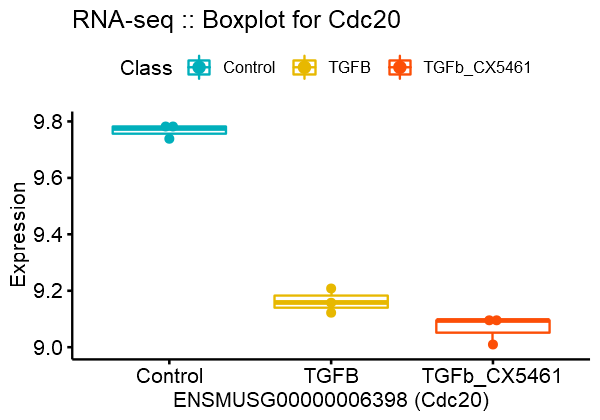

In [87]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Cdc20",
                xlab="ENSMUSG00000006398 (Cdc20)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cdc20 Boxplot %s", condstr))

### Ribo-seq Cdc20

In [124]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [125]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000006398",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.133586 8.070811 8.167722 8.115070 8.083757 8.235585 8.145333 8.100240 
  RD0186 
8.076246

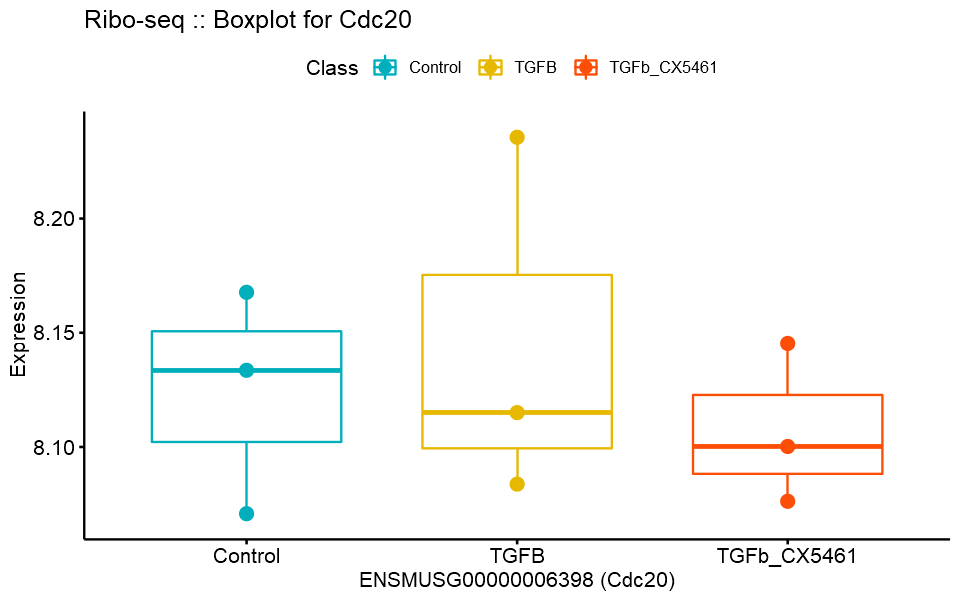

In [126]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdc20",
                xlab="ENSMUSG00000006398 (Cdc20)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cdc20 Boxplot %s", condstr))

## Plot for Gene: fizzy and cell division cycle 20 related 1 (Fzr1) ENSMUSG00000020235

### RNAseq Fzr1

In [91]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [92]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000020235",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.712925 9.697978 9.673688 9.455057 9.423491 9.340123 9.544700 9.451170 
 JBQS009 
9.489979

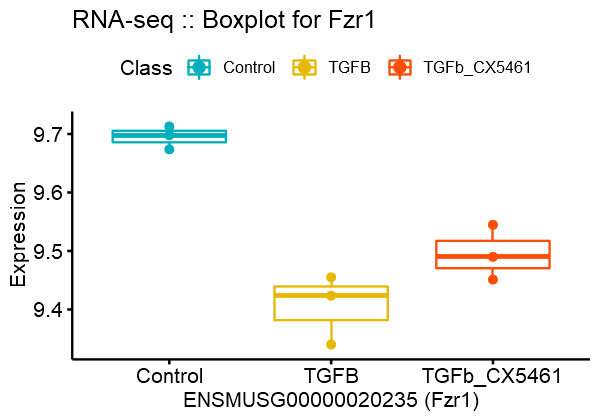

In [93]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Fzr1",
                xlab="ENSMUSG00000020235 (Fzr1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Fzr1 Boxplot %s", condstr))

### Ribo-seq Fzr1

In [94]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [95]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000020235",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.280799 8.305391 8.355385 8.330772 8.261962 8.290378 8.076106 8.288934 
  RD0186 
8.322553

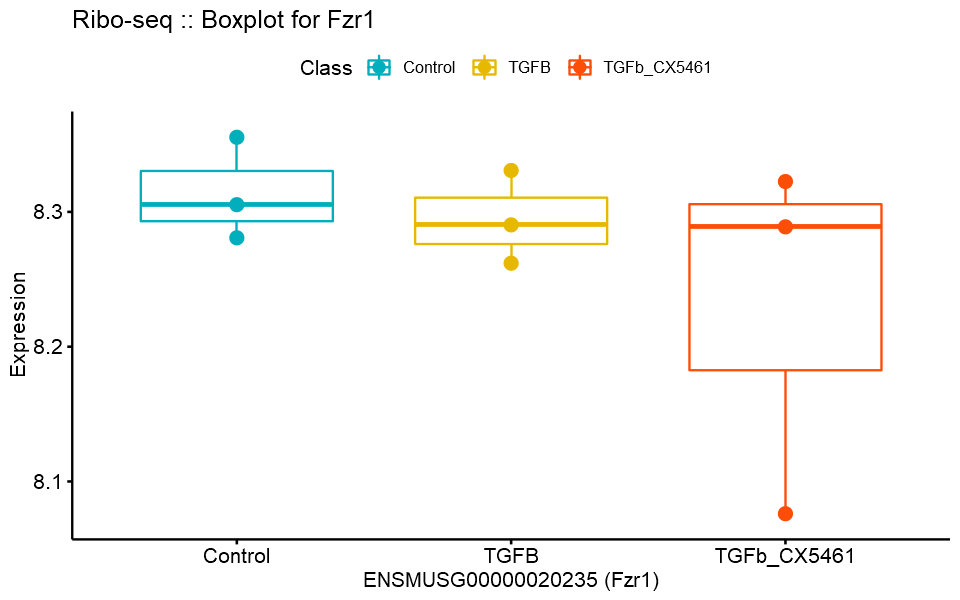

In [96]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Fzr1",
                xlab="ENSMUSG00000020235 (Fzr1)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Fzr1 Boxplot %s", condstr))

## Plot for Gene: cyclin-dependent kinase 4 (Cdk4) ENSMUSG00000006728

### RNAseq Cdk4

In [100]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [101]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000006728",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
11.40552 11.41713 11.42843 11.18982 11.19924 11.17134 11.16283 11.17553 
 JBQS009 
11.12543

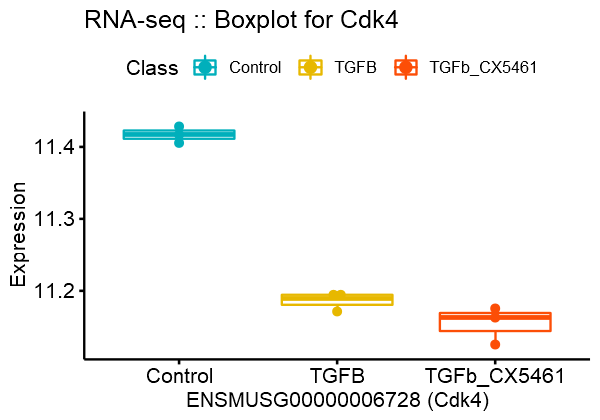

In [102]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Cdk4",
                xlab="ENSMUSG00000006728 (Cdk4)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cdk4 Boxplot %s", condstr))

### Ribo-seq Cdk4

In [103]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [104]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000006728",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.978910 8.800601 8.858919 8.724436 8.783800 8.751543 8.752742 8.729031 
  RD0186 
8.860595

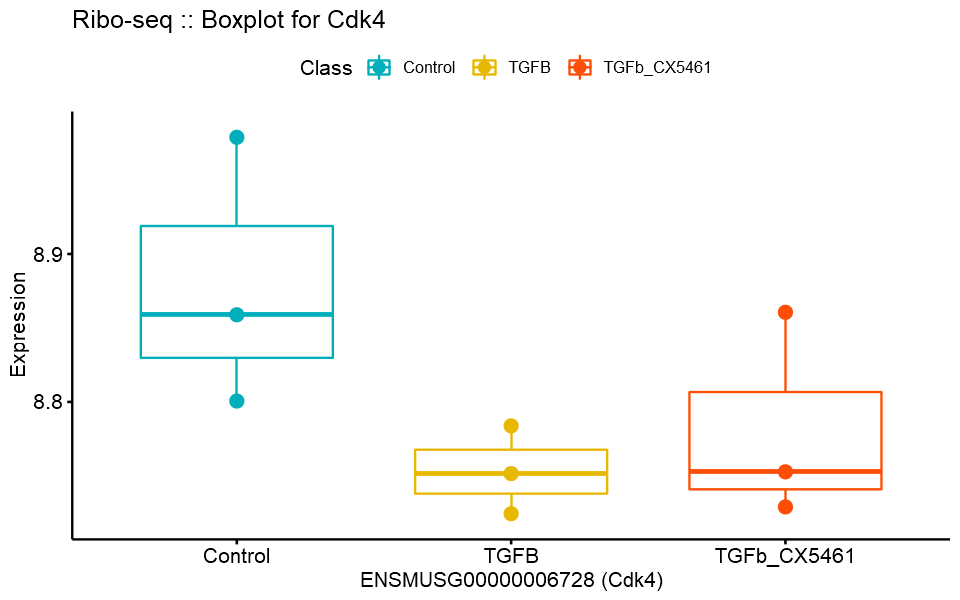

In [105]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdk4",
                xlab="ENSMUSG00000006728 (Cdk4)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cdk4 Boxplot %s", condstr))

In [ ]:
cyclin-dependent kinase 6 (Cdk6) ENSMUSG00000040274

## Plot for Gene: cyclin-dependent kinase 6 (Cdk6) ENSMUSG00000040274

### RNAseq Cdk6

In [112]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [113]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000040274",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001   JBQS002   JBQS003   JBQS004   JBQS005   JBQS006   JBQS007   JBQS008 
10.371616 10.330174 10.230785  9.746092  9.861659  9.828521  9.646674  9.643337 
  JBQS009 
 9.648677

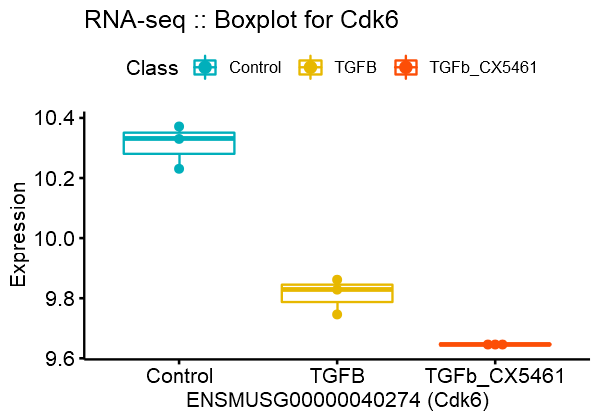

In [114]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Cdk6",
                xlab="ENSMUSG00000040274 (Cdk6)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cdk6 Boxplot %s", condstr))

### Ribo-seq Cdk6

In [115]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [116]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000040274",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.152277 8.363771 8.255167 8.192634 7.973097 8.281607 8.063343 8.059586 
  RD0186 
8.172604

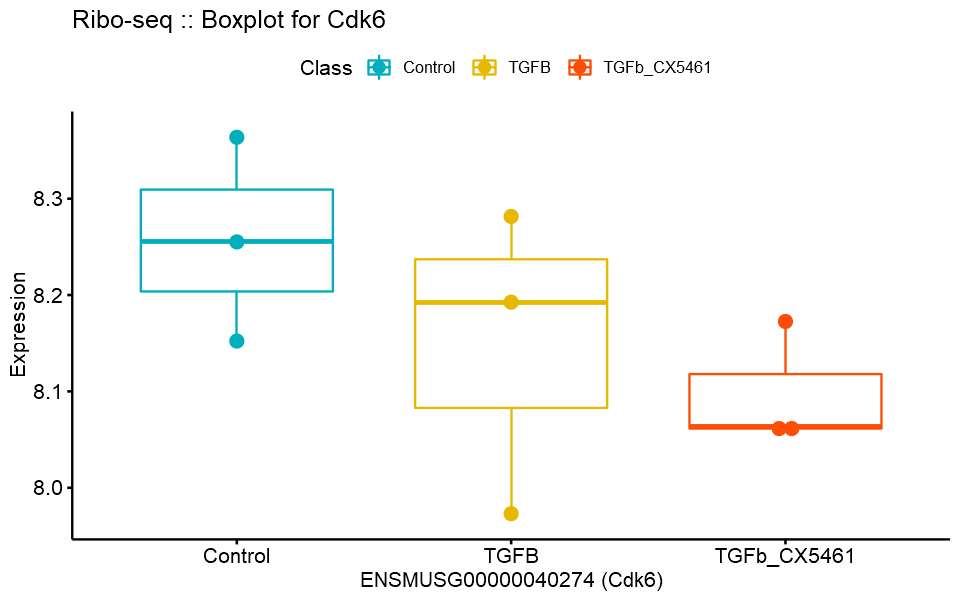

In [117]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdk6",
                xlab="ENSMUSG00000040274 (Cdk6)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cdk6 Boxplot %s", condstr))

In [ ]:
cyclin-dependent kinase inhibitor 1B (Cdkn1b:p27)

## Plot for Gene: cyclin-dependent kinase inhibitor 1B (Cdkn1b:p27) ENSMUSG00000003031

### RNAseq Cdkn1b/p27

In [151]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp)
sampleTable

ddsMat <- DESeqDataSetFromMatrix(countData = exp,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(ddsMat, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
ENSMUSG00000000001,9.846845,10.015898,9.907262,9.737121,9.868140,9.874579,9.772538,9.818249,9.855780
ENSMUSG00000000028,8.995601,9.013550,9.066349,8.877019,8.916123,8.896496,8.800030,8.749299,8.753080
ENSMUSG00000000056,9.545426,9.553182,9.606159,9.105323,9.194910,9.120690,9.199119,9.158936,9.206339


In [152]:
condstr <- "RNA-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000003031",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

JBQS001  JBQS002  JBQS003  JBQS004  JBQS005  JBQS006  JBQS007  JBQS008 
9.679731 9.889120 9.705052 9.332287 9.329485 9.387573 9.294141 9.341573 
 JBQS009 
9.319522

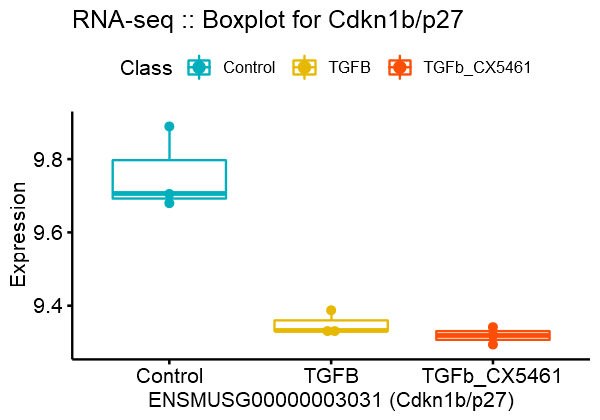

In [153]:
#ggdotplot(data, x = "Class", y = "Expression")
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="RNA-seq :: Boxplot for Cdkn1b/p27",
                xlab="ENSMUSG00000003031 (Cdkn1b/p27)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 5, height = 3.5, file = sprintf("RNA-seq Cdkn1b (p27) Boxplot %s", condstr))

### Ribo-seq Cdkn1b/p27

In [154]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(exp.Ribo)
sampleTable
dds.Ribo <- DESeqDataSetFromMatrix(countData = exp.Ribo,
                                 colData = sampleTable,
                                 design = ~ condition)
vsd <- vst(dds.Ribo, blind = FALSE)
head(assay(vsd), 3)

,condition
,<fct>
RD0175,Control
RD0176,Control
RD0177,Control
RD0178,TGFB
RD0179,TGFB
RD0180,TGFB
RD0184,TGFb_CX5461
RD0185,TGFb_CX5461
RD0186,TGFb_CX5461


converting counts to integer mode



,RD0175,RD0176,RD0177,RD0178,RD0179,RD0180,RD0184,RD0185,RD0186
ENSMUSG00000000001,8.531863,8.505114,8.581665,8.470980,8.592754,8.503177,8.601628,8.547285,8.516868
ENSMUSG00000000028,8.025094,8.012356,8.032883,8.020030,8.008521,8.104560,8.076106,8.025966,8.091412
ENSMUSG00000000056,8.251471,8.144855,8.243532,8.163134,8.271274,8.216029,8.223895,8.109799,8.133855


In [155]:
condstr <- "Ribo-seq"
vst.exp <- assay(vsd)
Expression <- vst.exp["ENSMUSG00000040274",]
Class <- rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)
data <- as.data.frame(cbind(Expression, Class))
data$Expression <- as.numeric(data$Expression)
Expression

RD0175   RD0176   RD0177   RD0178   RD0179   RD0180   RD0184   RD0185 
8.152277 8.363771 8.255167 8.192634 7.973097 8.281607 8.063343 8.059586 
  RD0186 
8.172604

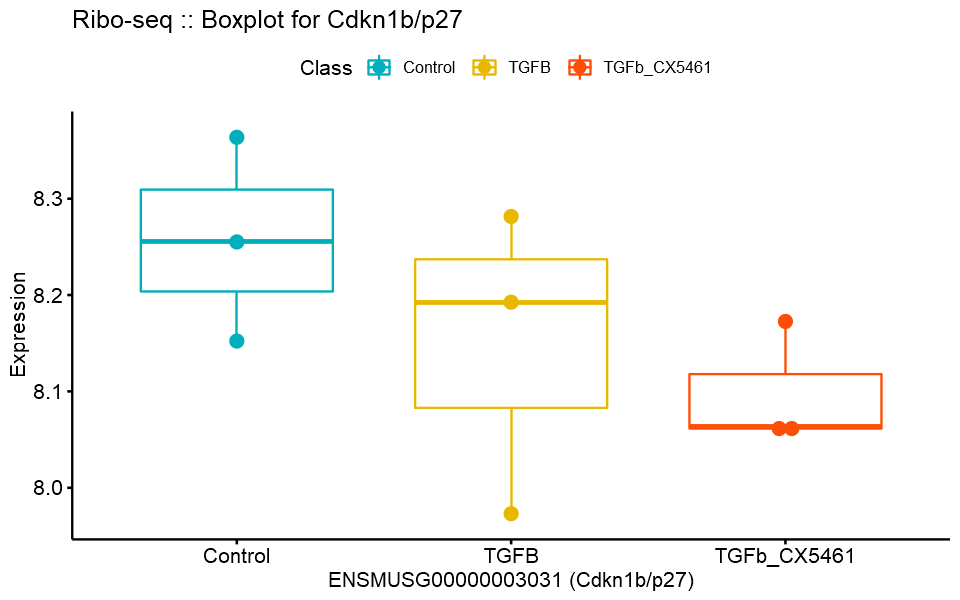

In [156]:
gp <- ggdotplot(data, "Class", "Expression",
                add = "boxplot",
                title="Ribo-seq :: Boxplot for Cdkn1b/p27",
                xlab="ENSMUSG00000003031 (Cdkn1b/p27)",
                color = "Class", fill = "Class",
                palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Ribo-seq Cdkn1b Boxplot %s", condstr))

## Proteomics and Phosphoproteomics data analysis

### Proteomics

#### Box plot for Cdk1

In [53]:
Whole_Proteome_quick_lysis <- read_tsv("Blancgrp_EMT_1Whole_Proteome_TMT_3totalcells_quick_lysis_v4.6.txt") %>%
select(where(~!all(is.na(.x)))) %>%
select('Gene name','US1','US3','TGFB1','TGFB2','TGFB3','TCX1','TCX2','TCX3')
#column_to_rownames('Gene name') %>% ## Lots of duplicated genes

New names:
* `` -> ...22
* `` -> ...23
* `` -> ...24
* `` -> ...25
* `` -> ...26
* ...

Rows: 10298 Columns: 27
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr  (4): Gene name, Protein Accession #, Annotation, DE
dbl (17): WPG, PSM#, Peptide#, %Coverage, US1, US3, TGFB1, TGFB2, TGFB3, TCX...
lgl  (6): ...22, ...23, ...24, ...25, ...26, ...27

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [54]:
Cdk1.WP <- Whole_Proteome_quick_lysis[Whole_Proteome_quick_lysis$'Gene name'%in%"Cdk1",] %>%
column_to_rownames('Gene name') %>%
log2()

sampleTable <- data.frame(condition = factor(c("Control","Control","TGFB","TGFB","TGFB", "TGFb_CX5461","TGFb_CX5461","TGFb_CX5461")))
rownames(sampleTable) <- colnames(Cdk1.WP)
sampleTable
data <- cbind(t(Cdk1.WP), as.character(sampleTable$condition))
colnames(data)[2] <- "Condition"
data <- as.data.frame(data)
data$Cdk1 <- as.numeric(data$Cdk1)

,condition
,<fct>
US1,Control
US3,Control
TGFB1,TGFB
TGFB2,TGFB
TGFB3,TGFB
TCX1,TGFb_CX5461
TCX2,TGFb_CX5461
TCX3,TGFb_CX5461


,Cdk1,Condition
,<dbl>,<chr>
US1,21.12692,Control
US3,21.05590,Control
TGFB1,20.17036,TGFB
TGFB2,20.08213,TGFB
TGFB3,20.19460,TGFB
TCX1,20.06907,TGFb_CX5461
TCX2,20.05590,TGFb_CX5461
TCX3,20.02918,TGFb_CX5461


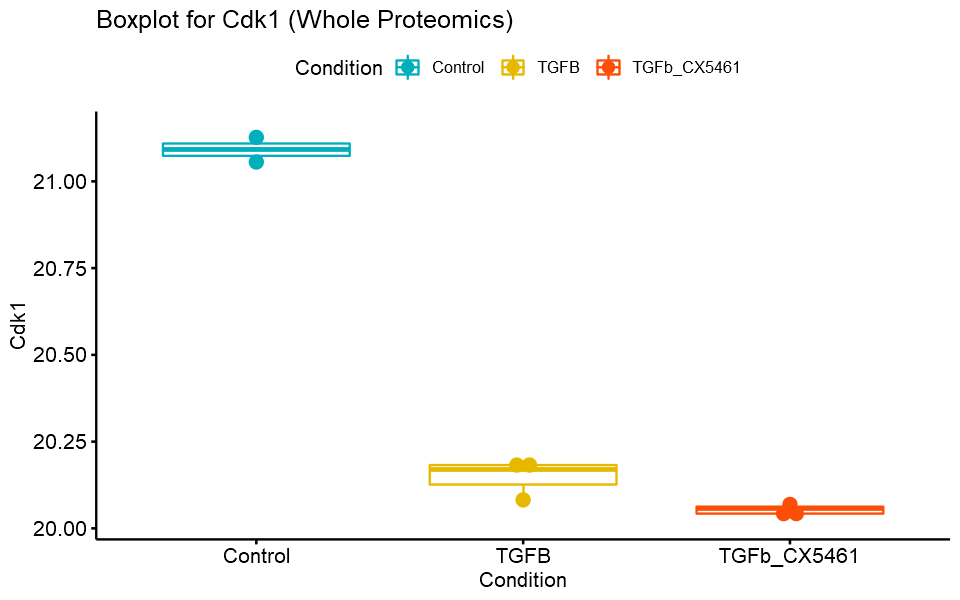

In [55]:
gp <- ggdotplot(data, "Condition", "Cdk1",
     add = "boxplot",
                title="Boxplot for Cdk1 (Whole Proteomics)",
      color = "Condition", fill = "Condition",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Whole Proteomics Cdk1a Boxplot"))

### Phosphoproteomics

#### Box plot for Cdk1

In [56]:
Whole_Phospho_Proteome_quick_lysis <- read_tsv("Blancgrp_EMT_2Phospho_Proteome_TMT_3totalcells_quick_lysis_v4.6.txt") %>%
select(where(~!all(is.na(.x)))) %>%
select('Gene name','US1','US3','TGFB1','TGFB2','TGFB3','TCX1','TCX2','TCX3')
#column_to_rownames('Gene name') %>% ## Lots of duplicated genes

New names:
* `` -> ...24
* `` -> ...25
* `` -> ...26
* `` -> ...27
* `` -> ...28
* ...

Rows: 11550 Columns: 29
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr  (7): Gene name, Protein Accession, Protein Annotation, Phosphopeptides,...
dbl (16): PPG, PSM#, Jscore, US1, US3, TGFB1, TGFB2, TGFB3, TCX1, TCX2, TCX3...
lgl  (6): ...24, ...25, ...26, ...27, ...28, ...29

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


<font color="purple"> <b> No phosphoproteomics data for Cdk1, So I am going commrnt out this part. </b> </font>

In [57]:
### No phosphoproteomics data for Cdk1
# No phosphoproteomics data for Ccnd1 (Cyclin-D1)

#### Box plot for Ccnd3 (Cyclin-D3)

,condition
,<fct>
US1,Control
US3,Control
TGFB1,TGFB
TGFB2,TGFB
TGFB3,TGFB
TCX1,TGFb_CX5461
TCX2,TGFb_CX5461
TCX3,TGFb_CX5461


,Ccnd3,Condition
,<dbl>,<chr>
US1,16.91998,Control
US3,16.76020,Control
TGFB1,16.89652,TGFB
TGFB2,16.95447,TGFB
TGFB3,16.86060,TGFB
TCX1,16.97701,TGFb_CX5461
TCX2,16.81127,TGFb_CX5461
TCX3,16.79867,TGFb_CX5461


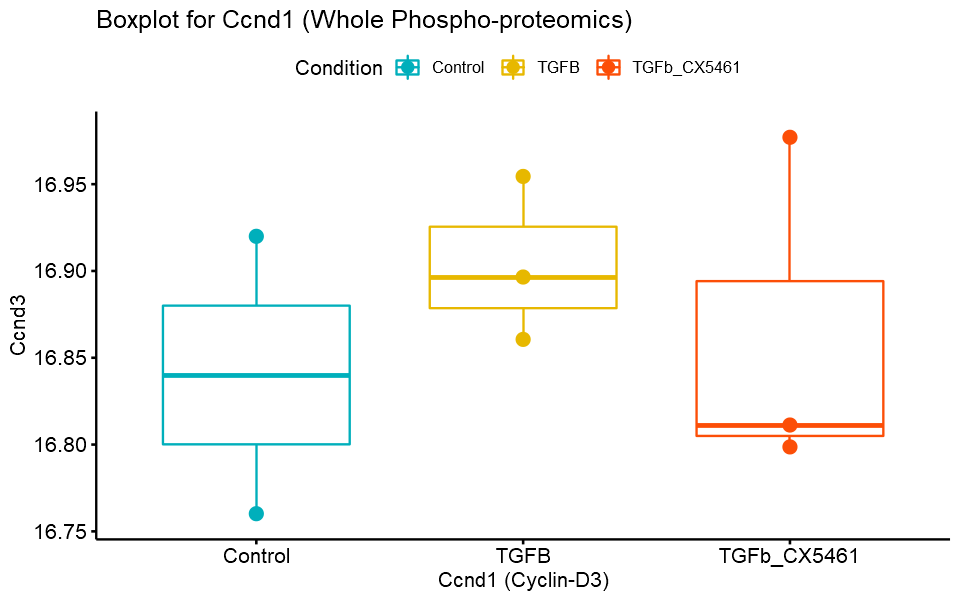

In [72]:

Ccnd3.WP <- Whole_Phospho_Proteome_quick_lysis[Whole_Phospho_Proteome_quick_lysis$'Gene name'%in%"Ccnd3",] %>%
column_to_rownames('Gene name') %>%
log2()

sampleTable <- data.frame(condition = factor(c("Control","Control","TGFB","TGFB","TGFB", "TGFb_CX5461","TGFb_CX5461","TGFb_CX5461")))
rownames(sampleTable) <- colnames(Ccnd3.WP)
sampleTable
data <- cbind(t(Ccnd3.WP), as.character(sampleTable$condition))
colnames(data)[2] <- "Condition"
data <- as.data.frame(data)
data$Ccnd3 <- as.numeric(data$Ccnd3)
data
gp <- ggdotplot(data, "Condition", "Ccnd3",
     add = "boxplot",
                title="Boxplot for Ccnd1 (Whole Phospho-proteomics)",
                xlab="Ccnd1 (Cyclin-D3)",
      color = "Condition", fill = "Condition",
      palette = c("#00AFBB", "#E7B800", "#FC4E07"))
print_figure(gp, width = 8, height = 5, file = sprintf("Whole Phosho-proteomics Ccnd1 (Cyclin-D3) Boxplot"))